In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-20 10:50:51.529303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 10:50:52.789084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# Additive Model: two-latent function model

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [3]:
def optimise_predict_model(model, epochs=50):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()
    
    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('number out of CI (train, test): ', number_outof_CI(y_train, mean_train, var_train), number_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Train


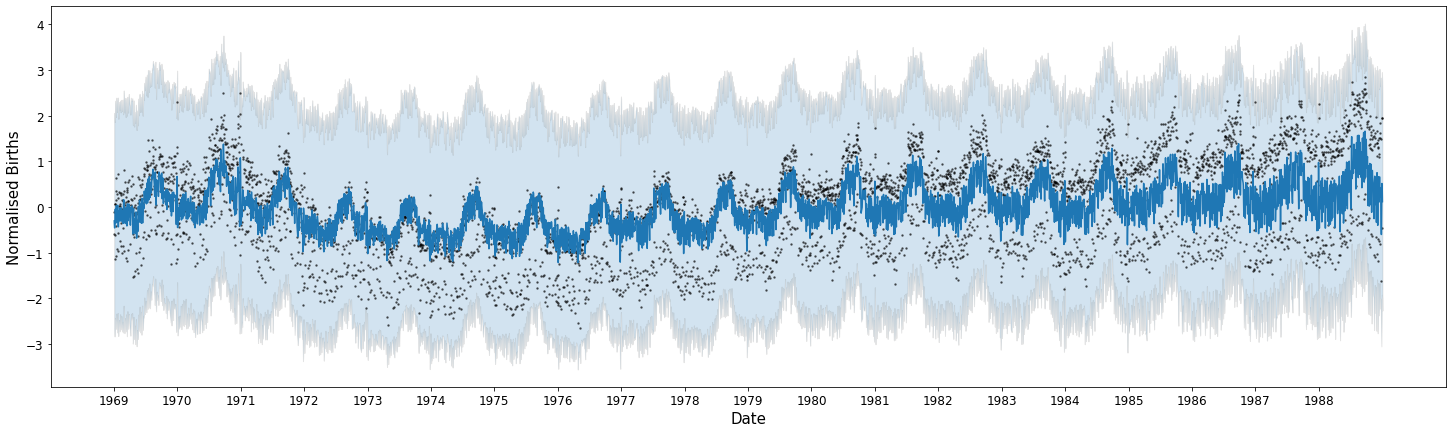

Test


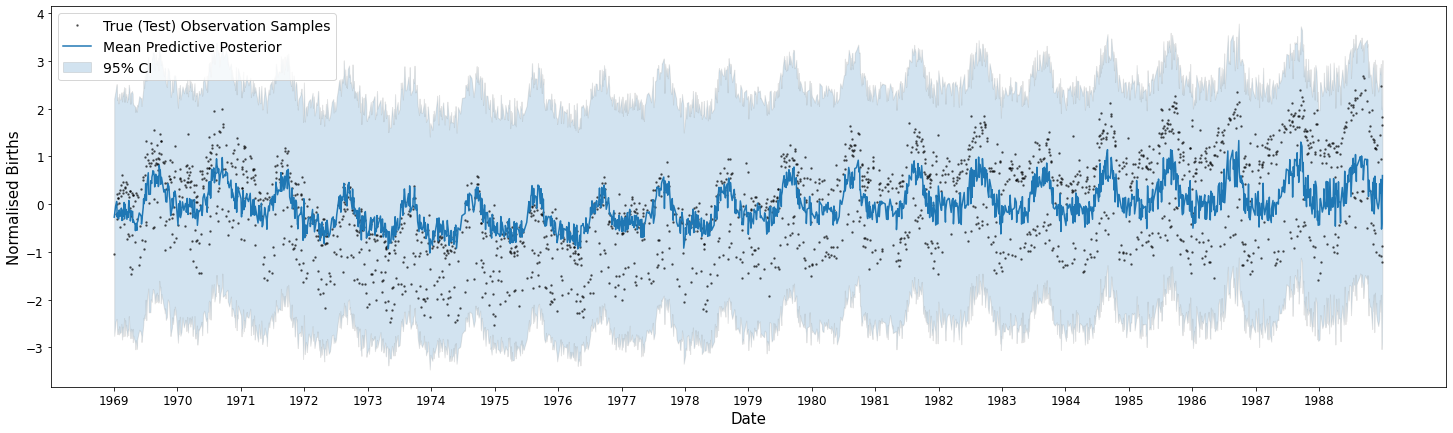

train ELBO, MSE, MAE:  -4469.392352747854 0.38588315323286343 0.5228403684454673
test ELBO, MSE, MAE:  -5101.011581339659 0.682195464906209 0.6998022600119403
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


--------------------------------------------------------
Train


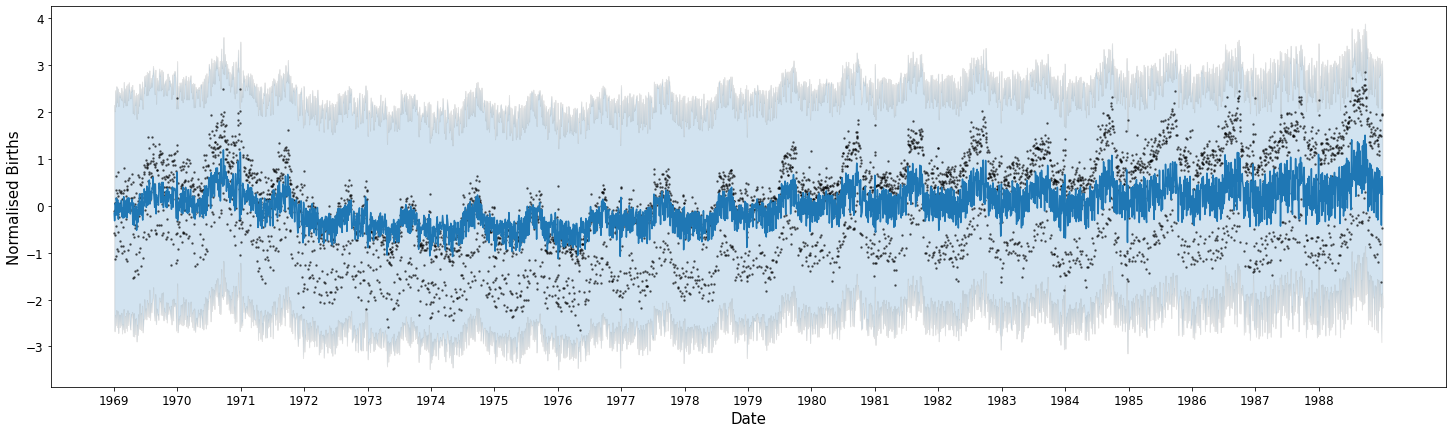

Test


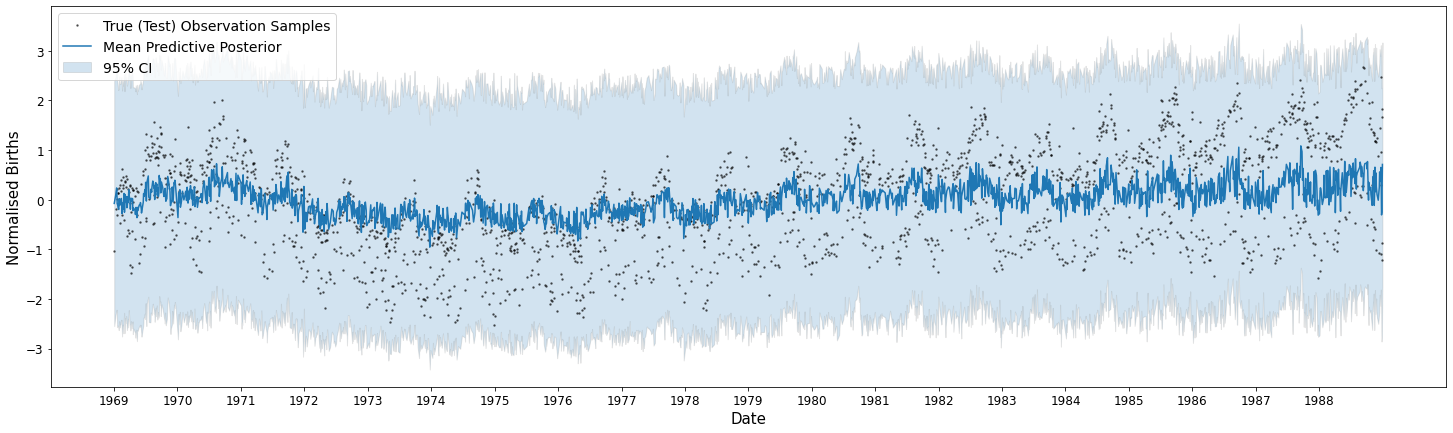

train ELBO, MSE, MAE:  -4568.850162988976 0.4205410119356521 0.5413587195782115
test ELBO, MSE, MAE:  -5175.055142592457 0.7255378282514874 0.7169554861114672
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0


--------------------------------------------------------


In [5]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Periodic(gpflow.kernels.RBF()), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

M = 3000

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = gpflow.kernels.RBF(lengthscales=1, variance=1) + kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    if i in [0,1]:
        model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(1), to_default_float(400))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.kernels[1].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

In [ ]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Periodic(gpflow.kernels.RBF()), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

M = 3000

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    if i in [0,1]:
        model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(1), to_default_float(400))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.kernels[1].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: periodic with set period bc CI is better.

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Value l:  1
Train


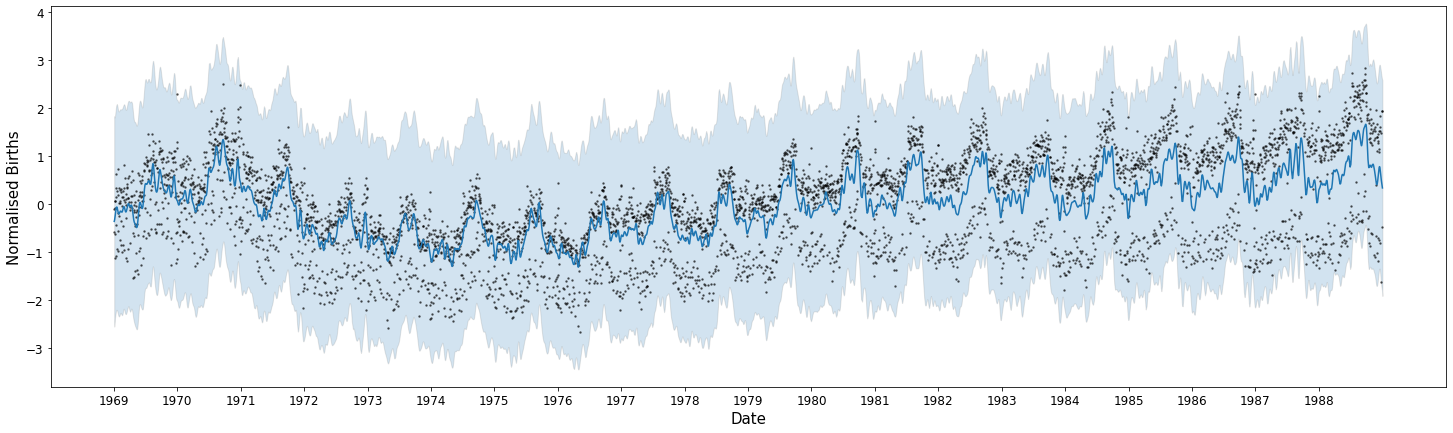

Test


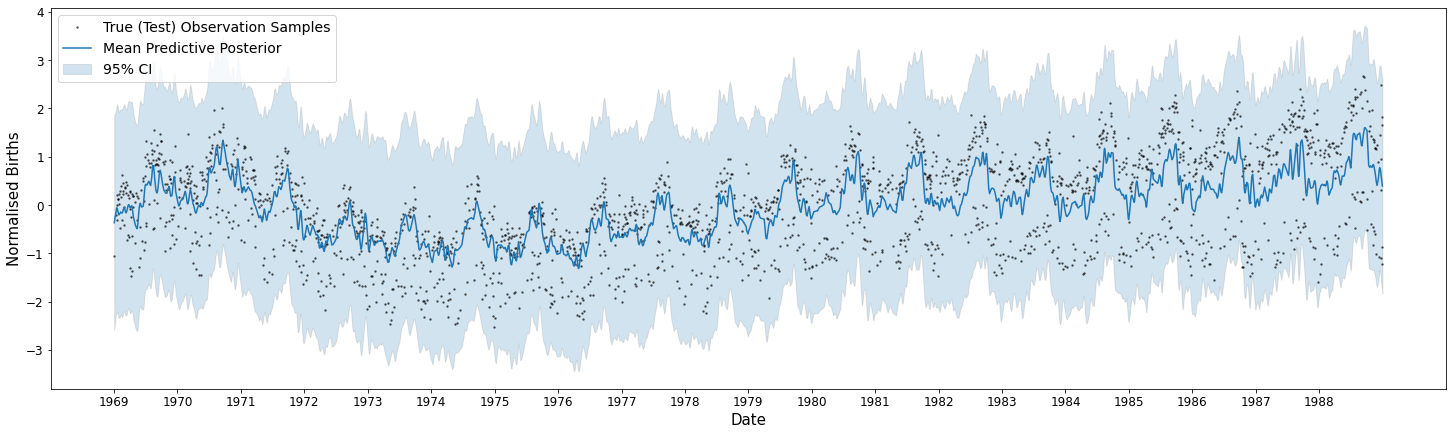

train ELBO, MSE, MAE:  -4117.625311425568 0.5239809806722077 0.6072759196727562
test ELBO, MSE, MAE:  -4349.1275358377625 0.657859512476488 0.6826257834899397
percentage out of CI (train, test):  0.058673968316057104 0.04562043795620438
number out of CI (train, test):  3 1


--------------------------------------------------------
Starting Value l:  5
Train


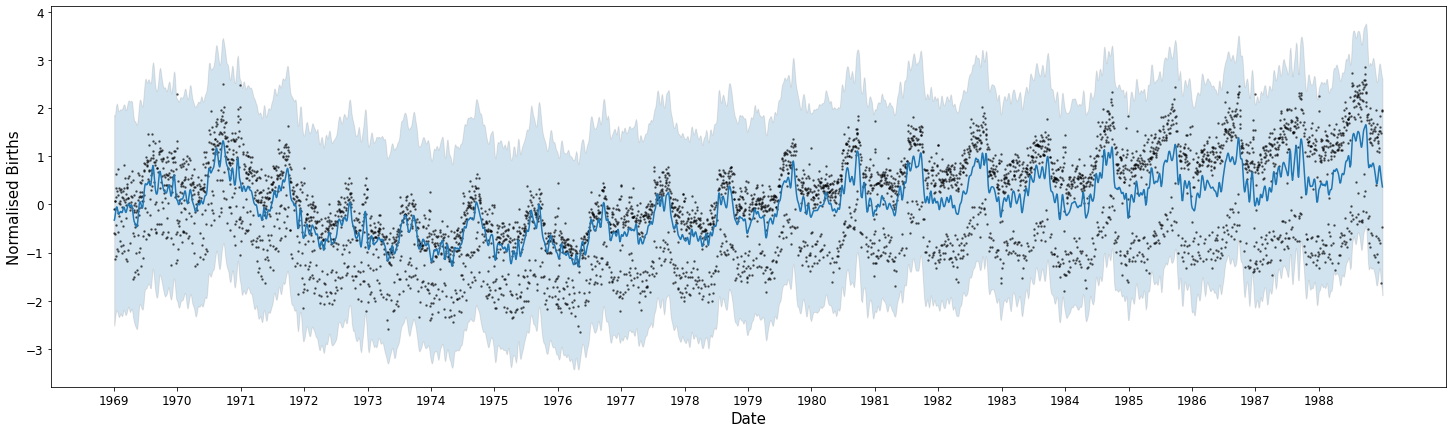

Test


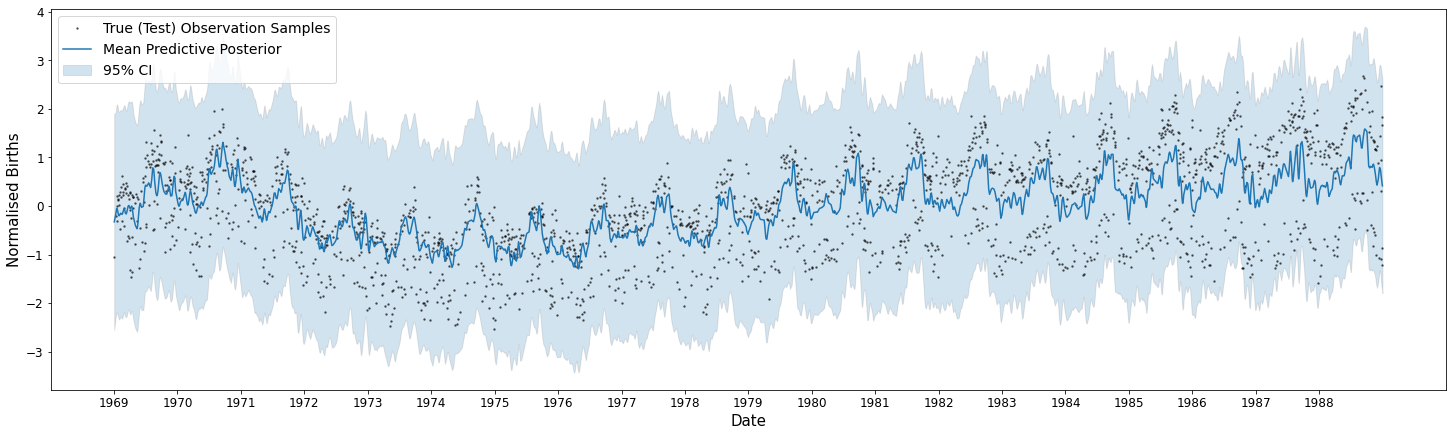

train ELBO, MSE, MAE:  -4121.2556995880905 0.524509983025546 0.6081367401370806
test ELBO, MSE, MAE:  -4354.916087319519 0.6598289918092831 0.6843449483397152
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Value l:  10
Train


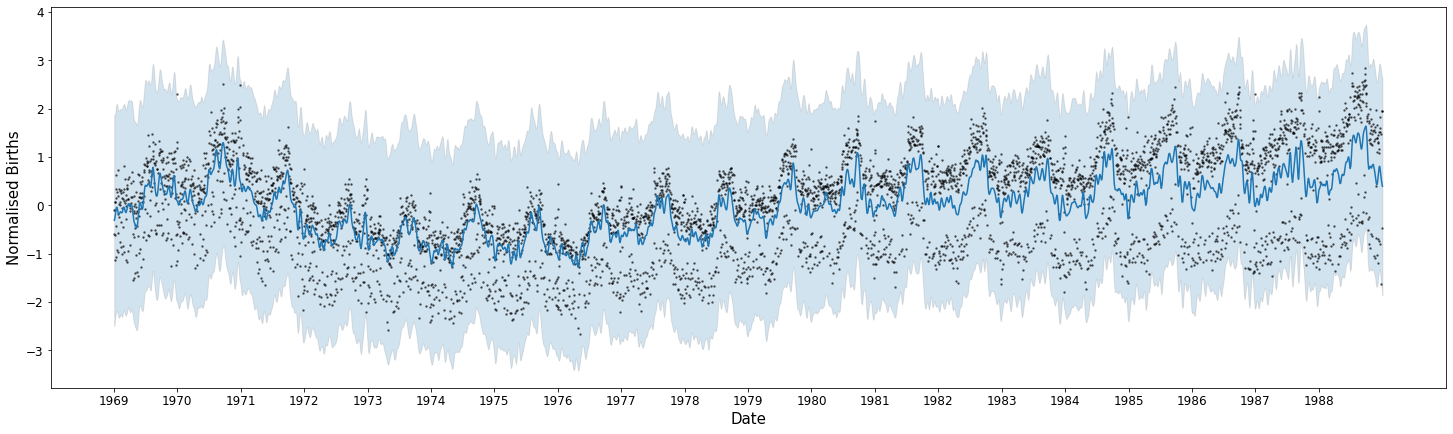

Test


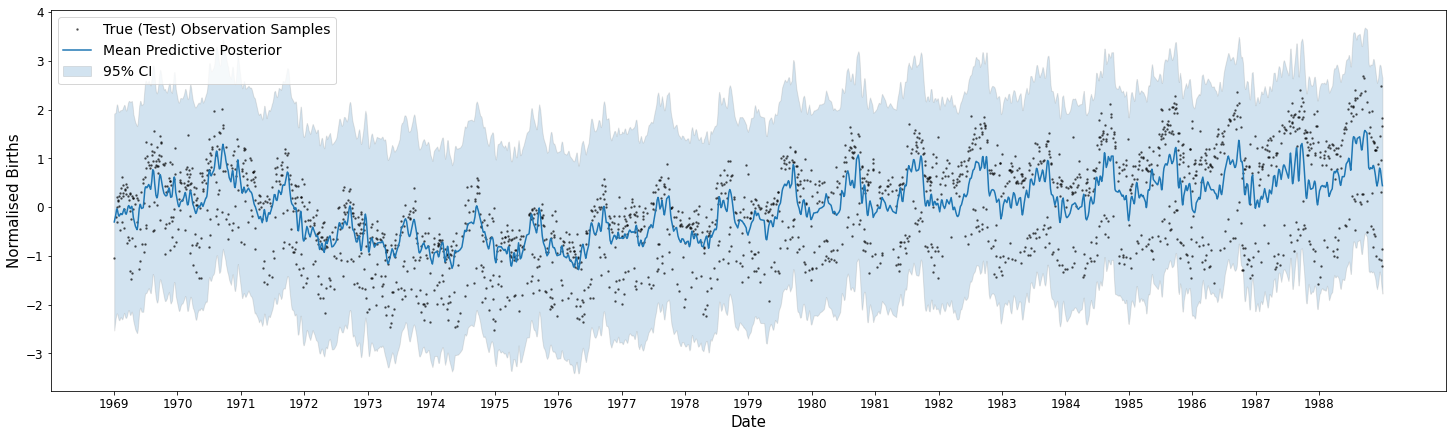

train ELBO, MSE, MAE:  -4126.040721837809 0.5250959606396579 0.6087395413076789
test ELBO, MSE, MAE:  -4358.788317461708 0.659789550794423 0.6845810260858561
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Value l:  19
Train


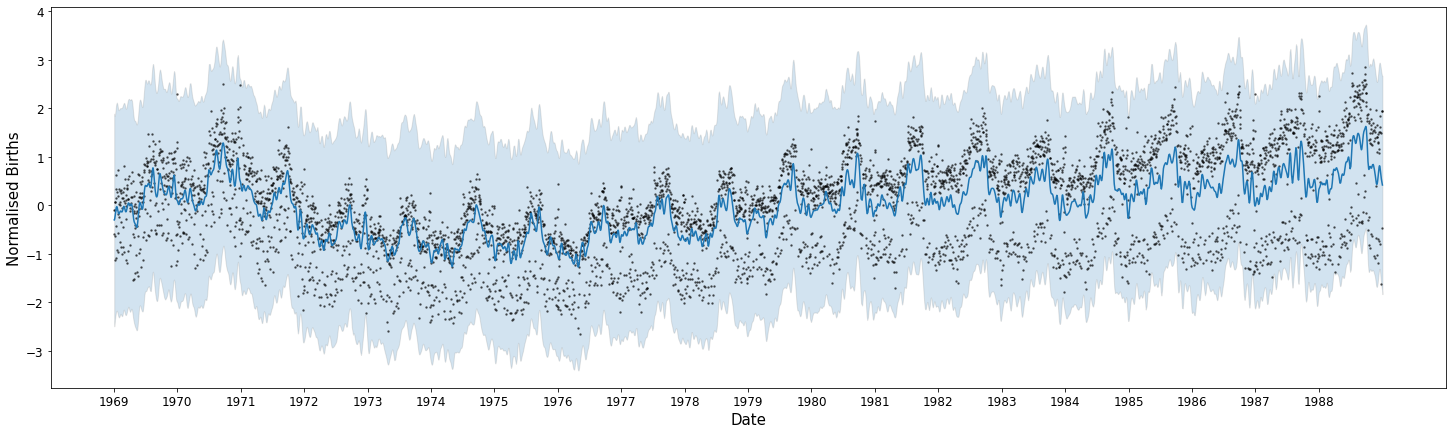

Test


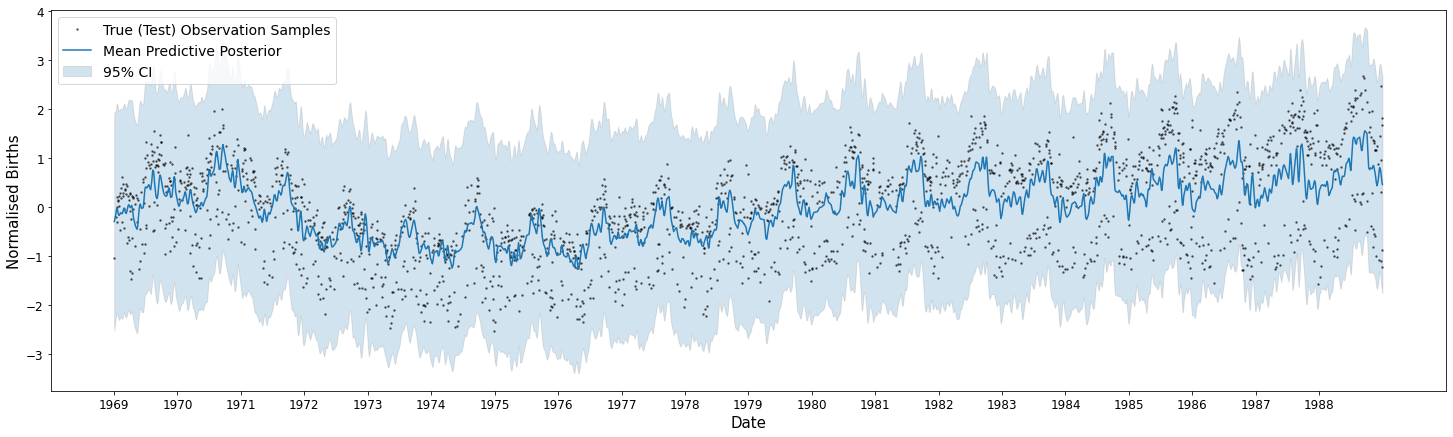

train ELBO, MSE, MAE:  -4129.769440163869 0.5258257325676745 0.6088006632504529
test ELBO, MSE, MAE:  -4362.061573493664 0.6602138909211464 0.6844540107461972
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------


In [7]:
starting_values_l = [1, 5, 10, 19]

M = 3000

for l in starting_values_l:
    print('Starting Value l: ', l)
    kernel = gpflow.kernels.RBF(lengthscales=7, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=l), period=365.25)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

Starting Value p:  1
Train


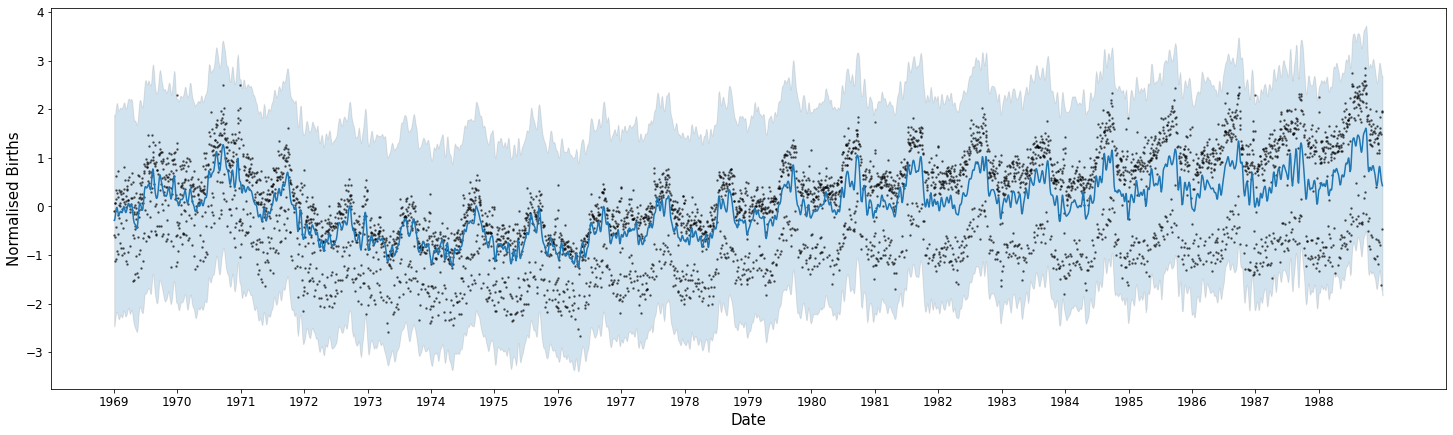

Test


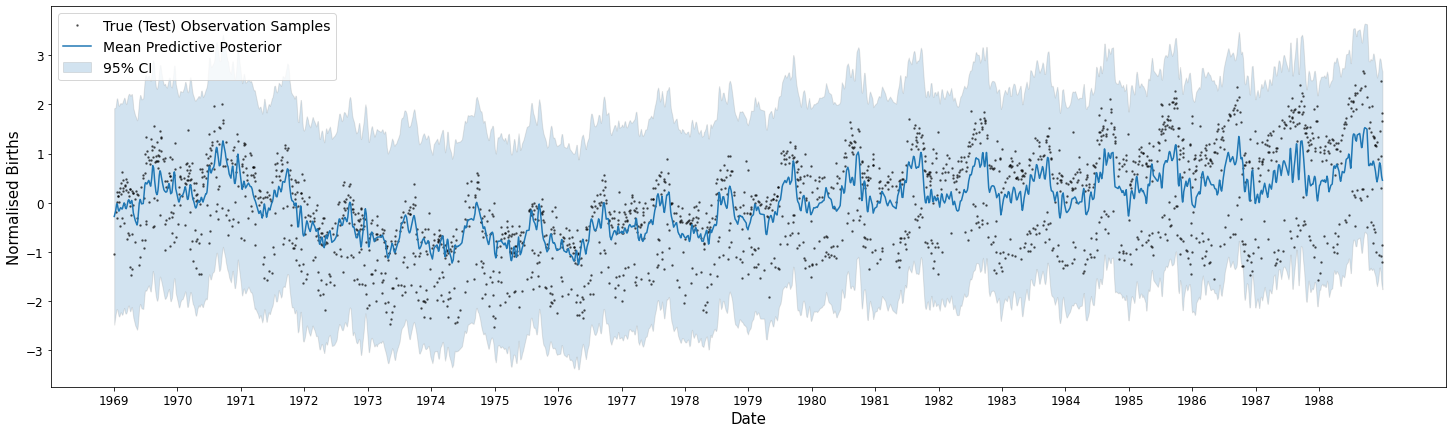

train ELBO, MSE, MAE:  -4158.689908693779 0.5261614816020485 0.6083239940122078
test ELBO, MSE, MAE:  -4403.3777409624 0.66694330063971 0.6873795972543632
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Value p:  30
Train


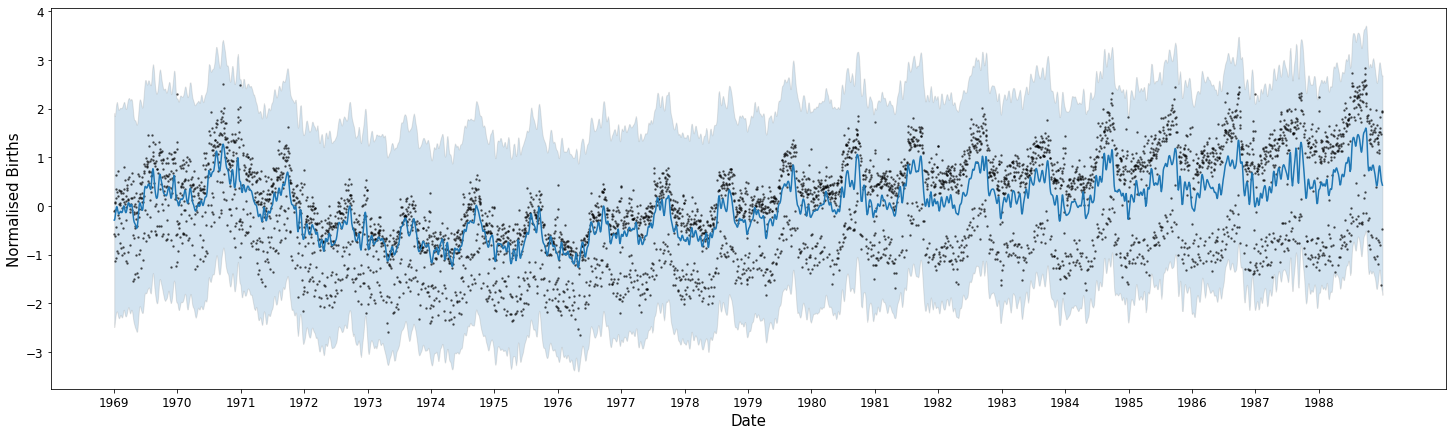

Test


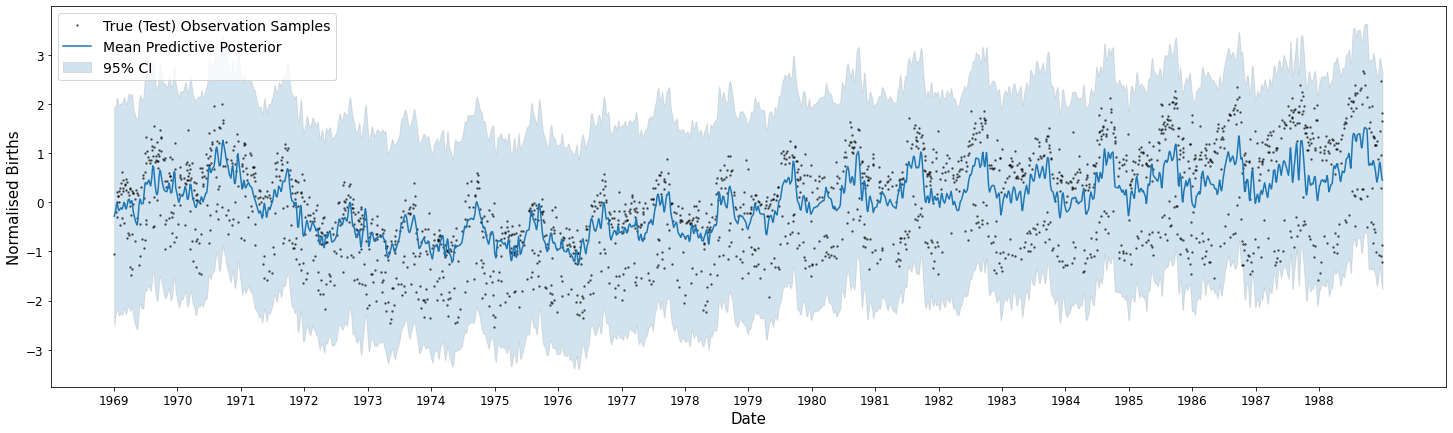

train ELBO, MSE, MAE:  -4155.297015304131 0.5261167248029887 0.6086811256763074
test ELBO, MSE, MAE:  -4400.530219133781 0.667002163403539 0.6877645232563901
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438
number out of CI (train, test):  2 1


--------------------------------------------------------
Starting Value p:  365
Train


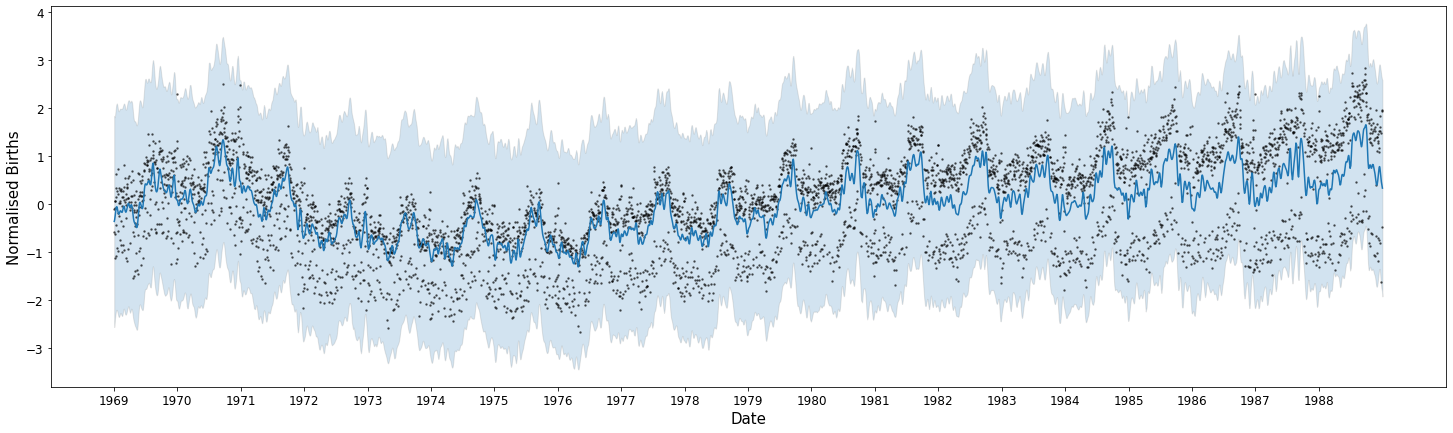

Test


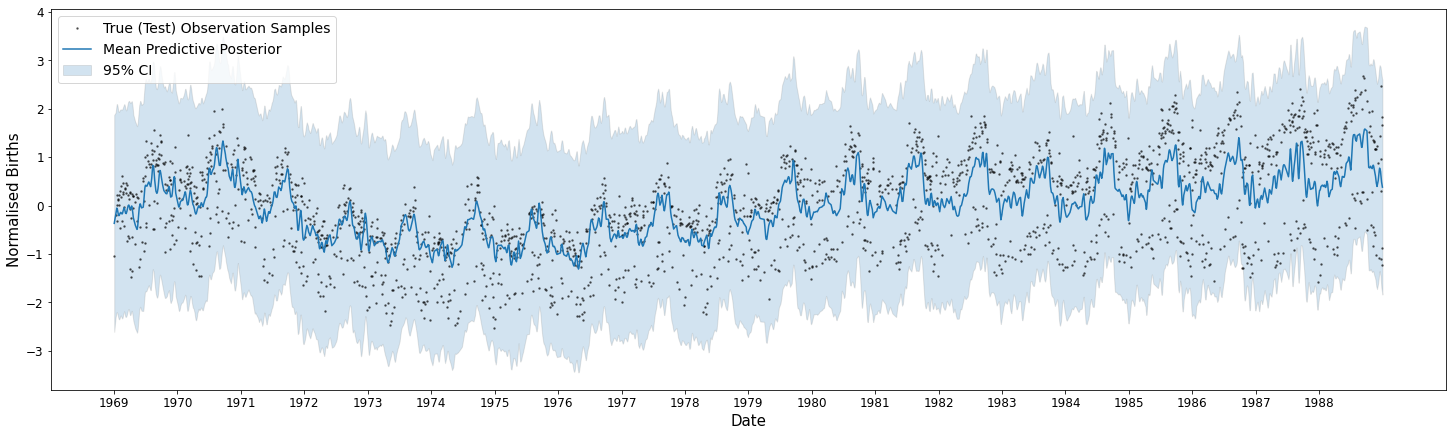

train ELBO, MSE, MAE:  -4133.812656497737 0.5236334833733568 0.6067287752408095
test ELBO, MSE, MAE:  -4377.388872383306 0.6636641186229999 0.6854613539847341
percentage out of CI (train, test):  0.058673968316057104 0.04562043795620438
number out of CI (train, test):  3 1


--------------------------------------------------------


In [9]:
starting_values_p = [1, 30, 365]

M = 3000

for p in starting_values_p:
    print('Starting Value p: ', p)
    kernel = gpflow.kernels.RBF(lengthscales=7, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=p)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    set_trainable(model.kernel.kernels[0].lengthscales, False)
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(1), to_default_float(365.5))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

In [ ]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Periodic(gpflow.kernels.RBF()), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

M = 3000

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = gpflow.kernels.RBF(lengthscales=77, variance=1) + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(1), to_default_float(400))
    model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    if i in [0,1]:
        model.kernel.kernels[2].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[2].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.kernels[2].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[2].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')